In [1]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')

In [2]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [3]:
#sqqq and tqqq are taken as IBdata feed not for SPXS 
path = '/home/octo/Dropbox/IQ_data/'
spy=pd.read_csv(path + 'SPY.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
sqqq= pd.read_csv(path + 'SQQQ.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
tqqq=pd.read_csv(path + 'TQQQ.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
spy=spy.tail(140000)
sqqq=sqqq.tail(140000)
tqqq=tqqq.tail(140000)

In [4]:
#df for datascience
df=pd.DataFrame(data=spy.open)
df['close']=pd.DataFrame(data=spy.close)
#df_ml for machine learning
df_ml=pd.DataFrame(data=spy.open)

## Features

##### Y

In [5]:
df['j']=pd.DataFrame(data=spy.open-spy.close.shift(60))
df['jQtop']=pd.rolling_quantile(df.j,1000,.95)-0.005
df['jQbot']=pd.rolling_quantile(df.j,1000,.05)+0.005
df['jump'] = np.where(df.j>df.jQtop,1,np.where(df.j<df.jQbot,-1,0))
df_ml['jump']=df['jump']

### x

In [6]:
df['NL']=pd.DataFrame(data=spy.open-spy.close.shift(300))
#df['spread']=df.open -df['vwap']
df['NLqtop']=pd.rolling_quantile(df.NL,1000,.95)
df['NLqbot']=pd.rolling_quantile(df.NL,1000,.05)
df['NLb']=np.where(df.NL>df.NLqtop,1,np.where(df.j<df.NLqbot,-1,0))
df_ml['NL']=np.where(pd.rolling_sum(df['NLb'],60)>0,1,np.where(pd.rolling_sum(df['NLb'],60)<0,-1,0))

In [7]:
P=(spy.high+spy.low+spy.close)/3
df['vwap'] =pd.rolling_sum(spy.volume*P,12)/pd.rolling_sum(spy.volume,12)
df['spread']=pd.rolling_sum(pd.DataFrame(data=(spy.open-df.vwap)),60)
df['spreadqtop']=pd.rolling_quantile(df.spread,1000,.95)
df['spreadqbot']=pd.rolling_quantile(df.spread,1000,.05)
df['spreadb']=np.where(df.spread>df.spreadqtop,1,np.where(df.spread<df.spreadqbot,-1,0))
df_ml['spread']=df['spreadb']

In [8]:
df['speed']=pd.rolling_sum(pd.DataFrame(data=(spy.open-spy.close.shift(1))),60)
df['speedQtop']=pd.rolling_quantile(df.speed,1000,.9)
df['speedQbot']=pd.rolling_quantile(df.speed,1000,.1)
df['speedb']=np.where(df.speed>df.speedQtop,1,np.where(df.speed<df.speedQbot,-1,0))
df_ml['speed']=df['speedb']

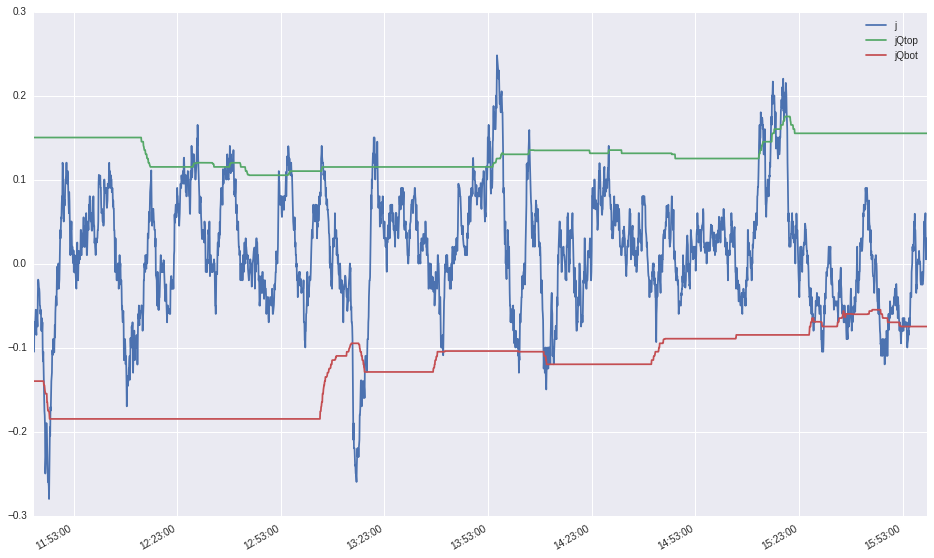

In [9]:
df[['j','jQtop','jQbot']].tail(3000).plot(figsize=(16, 10))
plt.show()

##### volume should be above 30% 

In [10]:
volQbot=pd.rolling_quantile(spy.volume,1000,.3)
df['vol']=np.where(spy.volume<volQbot,0,1)

### Signal

In [11]:
df['H']=pd.rolling_max(P,60)+pd.rolling_mean((spy.high-spy.low), window=60)-0.02
df['L']=pd.rolling_min(P,60)-pd.rolling_mean((spy.high-spy.low), window=60)+0.02

In [12]:
df['BS']=np.where(df.open<=df.L,1,np.where(df.open>=df.H,-1,0))
df_ml['BS']=df['BS']

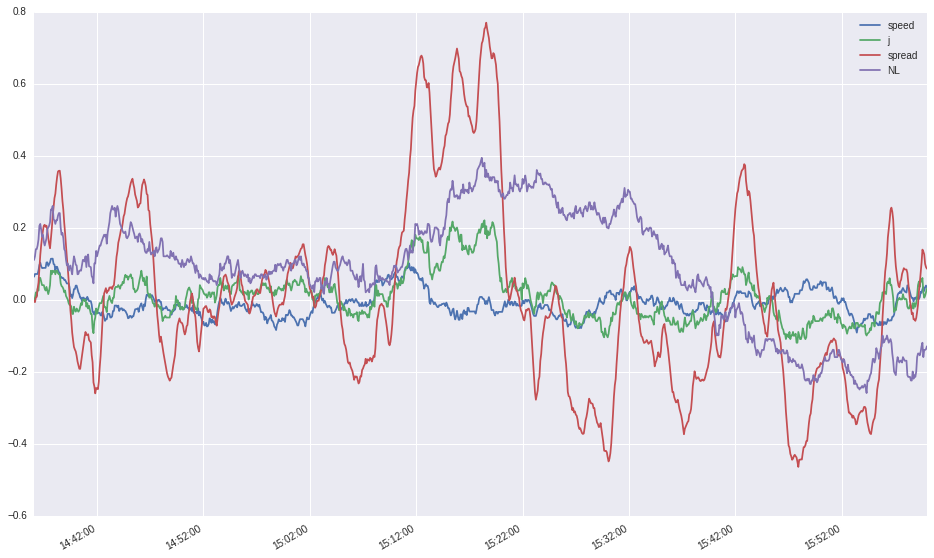

In [13]:
df[['speed','j','spread','NL']].tail(1000).plot(figsize=(16, 10))
plt.show()

#### NL out of quartile line will lead to jump. NL==-1 leads to jump==+1. So when NL will cross qunatile ( from 1 to 0 or -1 to 0) then we expect a reversion of jump line. NL from 1 (top) to 0 will lead to jump up or price increase rally of 0.25.

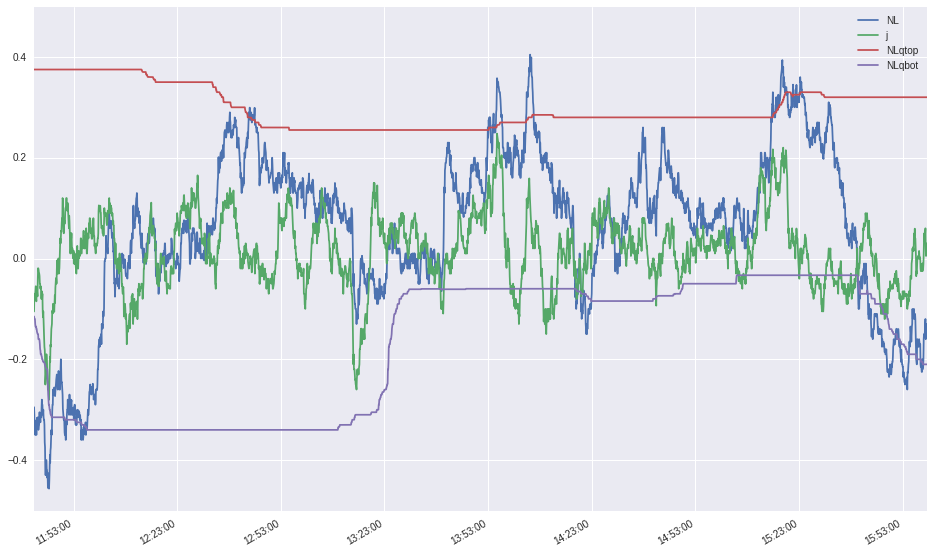

In [14]:
df[['NL','j','NLqtop','NLqbot']].tail(3000).plot(figsize=(16, 10))
plt.show()

##### speed is mean reverting. Will be used for buy/sell points. Buy when below quantile bottom and sell when above quantile top.
##### speed below bottom quantile and open below S then buy.

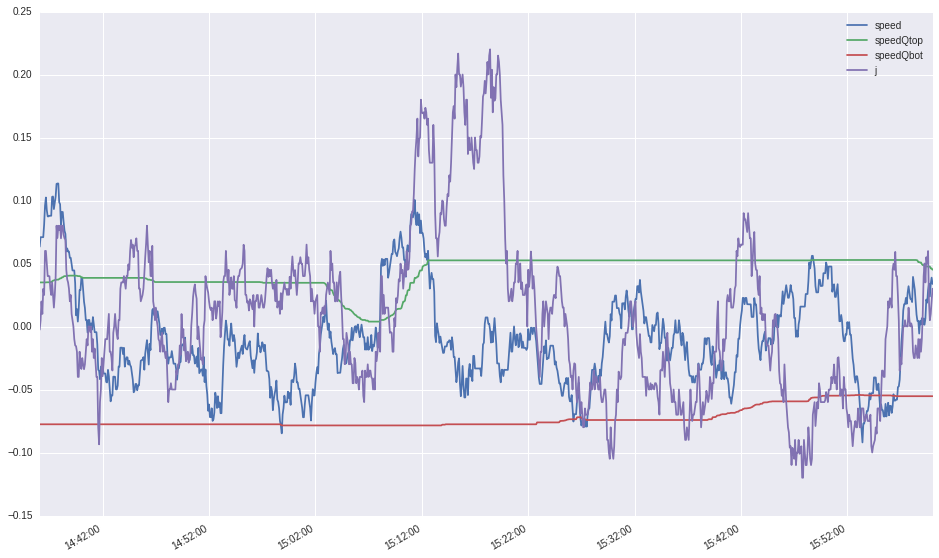

In [15]:
df[['speed','speedQtop','speedQbot','j']].tail(1000).plot(figsize=(16, 10))
plt.show()

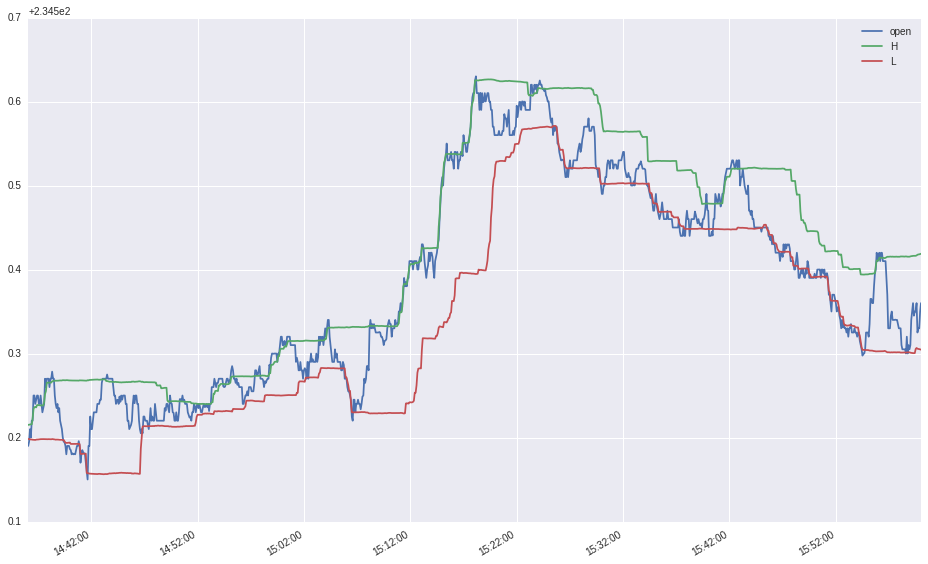

In [16]:
df[['open','H','L']].tail(1000).plot(figsize=(16, 10))
plt.show()

In [17]:
df_ml.tail()

,open,jump,NL,spread,speed,BS
2017-02-15 15:59:40,234.825,0,0,0,0,0
2017-02-15 15:59:45,234.830,0,0,0,0,0
2017-02-15 15:59:50,234.830,0,0,0,0,0
2017-02-15 15:59:55,234.850,0,0,0,0,0
2017-02-15 16:00:00,234.860,0,0,0,0,0


### Regression for feature generation

        Linear,SVR and ARCH based prediction



In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

In [19]:
p60=pd.DataFrame(data=spy.close.shift(60))
df=df.tail(130000)

In [20]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(pd.DataFrame(spy.open.tail(130000)),pd.DataFrame(p60.tail(130000)))
df['pr']=regr.predict(pd.DataFrame(p60.tail(130000)))

In [21]:
df['err']=df.open-df.pr
df['errQtop']=pd.rolling_quantile(df.err,1000,.95)
df['errQbot']=pd.rolling_quantile(df.err,1000,.05)
df['prb']=np.where(df.err>df.errQtop,1,np.where(df.err<df.errQbot,-1,0))
df_ml['err']=df['prb']

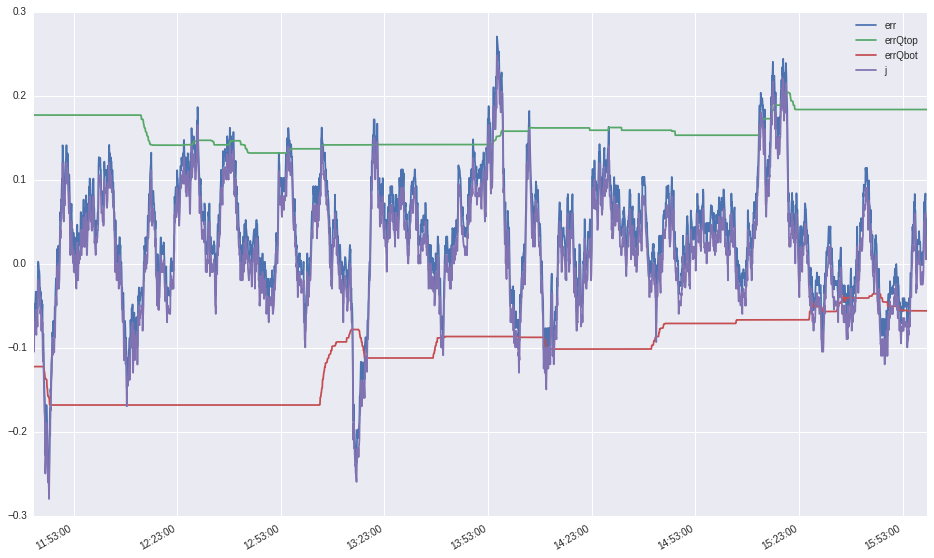

In [22]:
df[['err','errQtop','errQbot','j']].tail(3000).plot(figsize=(16, 10))
plt.show()

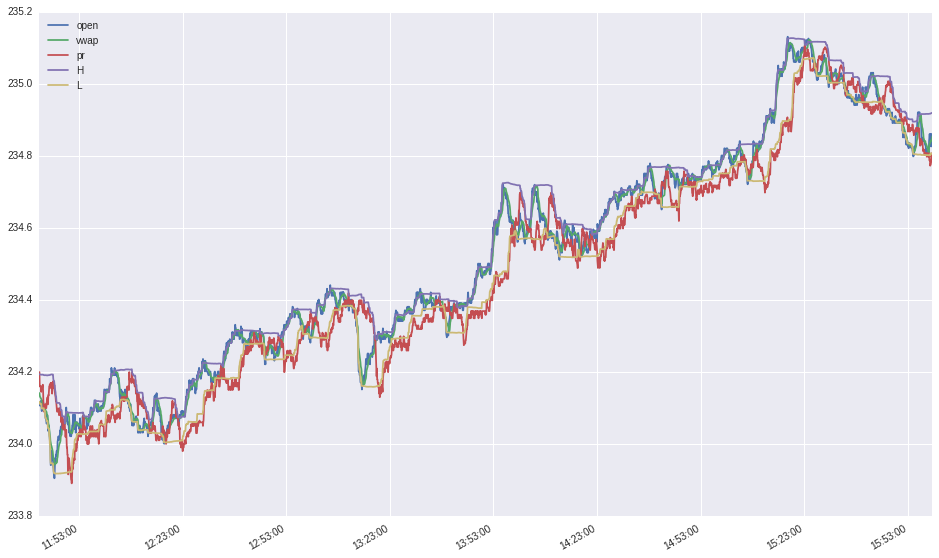

In [23]:
df[['open','vwap','pr','H','L']].tail(3000).plot(figsize=(16, 10))
plt.show()

## Machine Learning
        Predict BS
        Predict jump

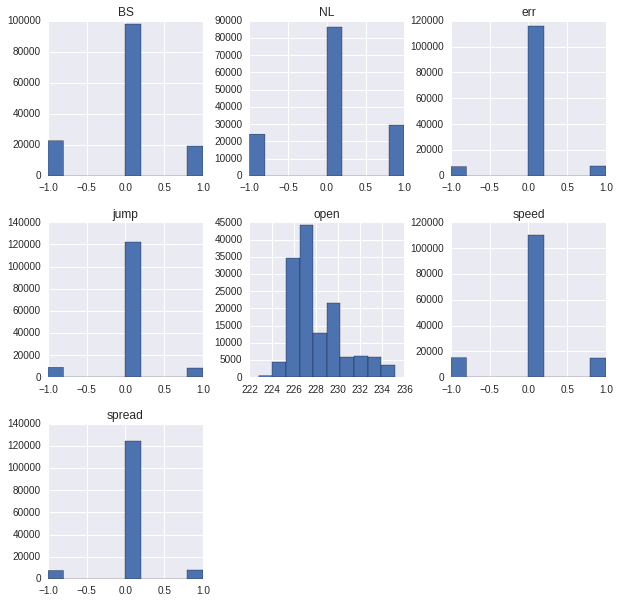

In [24]:
pd.DataFrame.hist(df_ml, figsize = [10,10]);

In [25]:
df_ml_bs=df_ml[df_ml.BS!=0]
df_ml_bs=df_ml_bs.dropna()

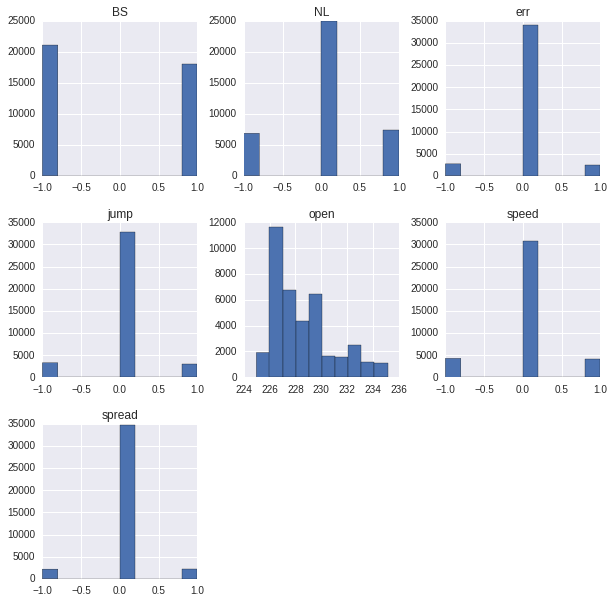

In [26]:
pd.DataFrame.hist(df_ml_bs, figsize = [10,10]);

In [31]:
#X=pd.DataFrame(df_svm[['volume_u','volume_d','ret_p','ret_n','Volatility','momentum','RSI']])
X=pd.DataFrame(df_ml_bs[['speed','spread','NL','err','jump']])
y=pd.DataFrame(df_ml_bs[['BS']])

In [32]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn import svm
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm_model = svm.fit(X_train, y_train)
print('SVC accuracy for test set: %f' % svm_model.score(X_test, y_test))

/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC accuracy for test set: 0.660796


In [34]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test,svm_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.63      0.94      0.75      4287
          1       0.82      0.32      0.46      3549

avg / total       0.72      0.66      0.62      7836



##### BS can not be predicted well as above

In [35]:
df_ml_jump=df_ml[df_ml.jump!=0]
df_ml_jump=df_ml_jump.dropna()

In [36]:
#X=pd.DataFrame(df_svm[['volume_u','volume_d','ret_p','ret_n','Volatility','momentum','RSI']])
X=pd.DataFrame(df_ml_jump[['speed','spread','NL','err']])
y=pd.DataFrame(df_ml_jump[['jump']])

In [37]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
from sklearn import svm
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm_model = svm.fit(X_train, y_train)
print('SVC accuracy for test set: %f' % svm_model.score(X_test, y_test))

SVC accuracy for test set: 0.967492


/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


In [39]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test,svm_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.99      0.94      0.97      1672
          1       0.95      0.99      0.97      1681

avg / total       0.97      0.97      0.97      3353



##### jump can be predicted well as above

In [51]:
#X=pd.DataFrame(df_svm[['volume_u','volume_d','ret_p','ret_n','Volatility','momentum','RSI']])
X=pd.DataFrame(df_ml_jump[['BS']])
y=pd.DataFrame(df_ml_jump[['jump']])

In [52]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
from sklearn import svm
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm_model = svm.fit(X_train, y_train)
print('SVC accuracy for test set: %f' % svm_model.score(X_test, y_test))

/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC accuracy for test set: 0.695795


In [54]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test,svm_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       1.00      0.39      0.56      1672
          1       0.62      1.00      0.77      1681

avg / total       0.81      0.70      0.66      3353

